# Stars

## Particle Stars

A `particle.Stars`object is the core object in synthesizer for modelling stellar distributions described by discrete particles (e.g. in hydrodynamical simulations).

To initialise one you need equal length arrays describing the ages, metallicities and initial masses of your star particles. These can then be provided directly to the Stars object on initialisation. In the example below, we make some mock data (with units) and load these into a particle ``Stars`` object:

In [1]:
import numpy as np
from synthesizer.particle import Stars
from unyt import Msun, Myr

N = 100
ages = np.random.rand(N) * 100 * Myr
metallicities = np.random.rand(N) / 100
initial_masses = np.ones(N) * 1e6 * Msun

stars = Stars(
    initial_masses=initial_masses,
    ages=ages,
    metallicities=metallicities,
)

The provided ages, metallicities and initial masses of the star particles describe the star formation and metal enrichment (SFZH) history. Some basic statistics of this object can be viewed by:

In [2]:
print(stars)

+------------------------------------------------------------------------------+
|                                    STARS                                     |
+-----------------------+------------------------------------------------------+
| Attribute             | Value                                                |
+-----------------------+------------------------------------------------------+
| nparticles            | 100                                                  |
+-----------------------+------------------------------------------------------+
| metallicity_floor     | 1.00e-05                                             |
+-----------------------+------------------------------------------------------+
| name                  | 'Stars'                                              |
+-----------------------+------------------------------------------------------+
| resampled             | False                                                |
+-----------------------+---

This can be visualised in synthesizer using a `Grid` object (see [here](../grids/grids.rst)), to assign these to SFZH bins.

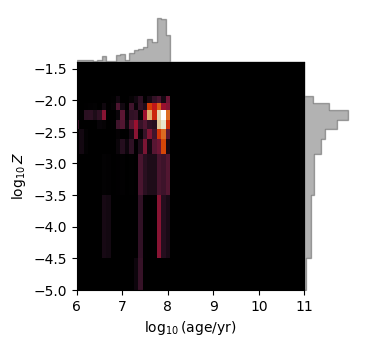

(<Figure size 350x350 with 3 Axes>,
 <Axes: xlabel='$\\log_{10}(\\mathrm{age}/\\mathrm{yr})$', ylabel='$\\log_{10}Z$'>)

In [3]:
from synthesizer.grid import Grid

grid_dir = "../../../tests/test_grid"
grid_name = "test_grid"

grid = Grid(grid_name, grid_dir=grid_dir)

stars.plot_sfzh(grid)

By providing a `Grid` to the `Stars` object one can generate the stellar emission.
This can include the integrated SED (see `Sed` [docs](../sed/sed.rst)), line emission (see `line` [docs](../lines/lines.rst)), as well as the per--particle SED and line luminosity / equivalent widths.

### Optional arguments

Any component can take arbitrary extra arguments. Some of these are pre-defined kwargs (e.g. ``coordinates``, ``redshift``, ``current_masses`` etc.), but any additional ``**kwargs`` will be unpacked and attached to the component instances (here a ``Stars`` instance). This is particularly useful when working with emission models that require component level attributes (e.g. particle specific optical depths).

In [4]:
tau_v = np.random.rand(N)
coordinates = np.random.normal(50, 0.005, (N, 3))
centre = np.array([50, 50, 50])
redshift = 5

stars = Stars(
    initial_masses=initial_masses,
    ages=ages,
    metallicities=metallicities,
    # Pre defined Quantitys
    coordinates=coordinates,
    centre=centre,
    # Optional argument
    redshift=redshift,
    current_masses=initial_masses - (np.random.rand(N) * 1e6 * Msun),
    # Arbitrary kwarg for modelling
    tau_v=tau_v,
)
print(stars)

+------------------------------------------------------------------------------+
|                                    STARS                                     |
+-----------------------+------------------------------------------------------+
| Attribute             | Value                                                |
+-----------------------+------------------------------------------------------+
| redshift              | 5                                                    |
+-----------------------+------------------------------------------------------+
| nparticles            | 100                                                  |
+-----------------------+------------------------------------------------------+
| metallicity_floor     | 1.00e-05                                             |
+-----------------------+------------------------------------------------------+
| name                  | 'Stars'                                              |
+-----------------------+---

### Computing characteristics radii

Characteristic radii can be computed for the stellar particle distribution. We can either calculate the half-mass radius.

In [5]:
r = stars.get_half_mass_radius()
print(r)

0.008551529686949687 Mpc


Or use an aribtrary attribute for the radius weight. Here we'll use the optical depth for a "half tau_V radius".

In [6]:
r = stars.get_attr_radius("tau_v")
print(r)

0.008618028493307835 Mpc


We can also compute radii for different fractions by passing the fraction we want to calculate a radius for.

In [7]:
r20 = stars.get_attr_radius("masses", frac=0.2)
r80 = stars.get_attr_radius("masses", frac=0.8)
print(r20, r80)

0.004152447883111465 Mpc 0.01162786583655812 Mpc


We can also calculate characteristic light radii from photometry. See the [photometry](../photometry/galaxy_phot.ipynb) documentation for more details.

## Parametric Stars

The core element of the parametric modelling in synthesizer is the `parametric.Stars` object. This contains everything necessary to describe a stellar population including:

- A 2D SFZH grid containing the stellar mass formed in stellar age and metallicity bins.

- A `Morphology` object describing it's distribution (optional but required for imaging).

- The axes of the SFZH grid.

- The total initial stellar mass.

And if calculated by the user:

- The [stellar spectra](../spectra/stars.ipynb).

- [Line luminosities](../lines/lines.rst).

There are a number of different methods to define a parametric stellar population (from here on a `Stars` object). In what follows we will focus on user defined values/arrays but note that each different method could instead use simulated data (e.g. from Semi Analytic Models) rather than user defined values.

The possible ways of defining a `Stars` object are (the age and metallicity axis of the SFZH must always be supplied):

- Explictly providing the SFZH grid itself. Note that this will mean all other definitions below are ignored.

- Providing singular age and metallicity values to define an "instantaneous" SFZH, i.e. one where all the stellar mass is in a single age and metallicity bin.

- Providing arrays which contain the SFH and metallicity distribution in terms of stellar mass formed.

- Providing SFH and metallcity distribution functions (from `parametric.sf_hist` and `parametric.metal_dist`). These will be used internally to compute the arrays from the previous point.

- Any combination of the above.

Below we simply import some packages and objects we'll need.

In [8]:
import numpy as np
from synthesizer.parametric import SFH, Stars, ZDist
from unyt import Myr

### Defining an instantaneous SFZH

To define an instantaneous SFZH we need only to provide the age and metallicity of the SFZH bin, alongside the SFZH axis arrays and the total initial mass of the `Stars` object. Note that the `log10ages` and `log10metallicites`/`metallicities` will likely come from a `Grid` object in most workflows (see the `Grid` [docs](../grids/grids.rst)).

In [9]:
# Create the SFZH axis arrays
log10ages = np.arange(6.0, 10.5, 0.1)  # log10(age/yr)
log10metallicities = np.arange(-5.0, -1.5, 0.25)
metallicities = 10**log10metallicities

# Get the instantaneous Stars
inst_stars = Stars(
    log10ages,
    metallicities,
    sf_hist=100 * Myr,
    metal_dist=10**-3,
    initial_mass=10**9,
)

To see the created SFZH you can print some basic statistics by printing the `Stars` object.

In [10]:
print(inst_stars)

+---------------------------------------------------------------------------+
|                                   STARS                                   |
+--------------------------+------------------------------------------------+
| Attribute                | Value                                          |
+--------------------------+------------------------------------------------+
| metallicity_grid_type    | 'log10Z'                                       |
+--------------------------+------------------------------------------------+
| log10ages_lims           | [6.0,  10.399999999999984, ]                   |
+--------------------------+------------------------------------------------+
| metallicities_lims       | [1e-05,  0.01778279410038923, ]                |
+--------------------------+------------------------------------------------+
| log10metallicities_lims  | [-5.0,  -1.75, ]                               |
+--------------------------+------------------------------------

Or to probe the SFZH you can plot it using the provided helper function.

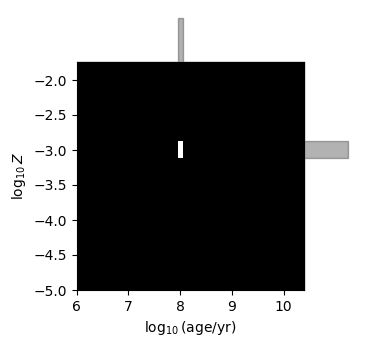

In [11]:
fig, ax = inst_stars.plot_sfzh(show=True)

### Defining a SFZH from arrays

Of course, most of the time you won't want an instantaneous SFZH but instead a distribution. One way to achieve this is to pass arrays describing the SFH and metallicity distribution. This is particularly useful if you have data explictly describing the ages and metallicities of a stellar population. However, here we'll demonstrate this with entirely unphysical arrays.

+---------------------------------------------------------------------------+
|                                   STARS                                   |
+--------------------------+------------------------------------------------+
| Attribute                | Value                                          |
+--------------------------+------------------------------------------------+
| metallicity_grid_type    | 'log10Z'                                       |
+--------------------------+------------------------------------------------+
| log10ages_lims           | [6.0,  10.399999999999984, ]                   |
+--------------------------+------------------------------------------------+
| metallicities_lims       | [1e-05,  0.01778279410038923, ]                |
+--------------------------+------------------------------------------------+
| log10metallicities_lims  | [-5.0,  -1.75, ]                               |
+--------------------------+------------------------------------

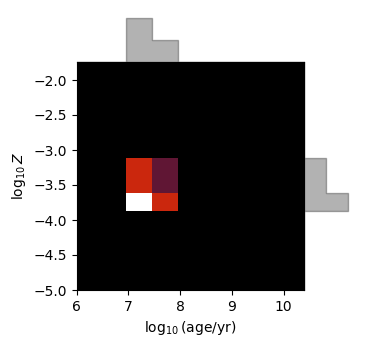

In [12]:
# Create arrays for SFH and ZDist
sf_hist = np.zeros_like(log10ages)
metal_dist = np.zeros_like(metallicities)
sf_hist[10:15] = 1
sf_hist[15:20] = 0.5
metal_dist[5:6] = 1
metal_dist[6:8] = 0.5

# Get the Stars
arr_stars = Stars(
    log10ages,
    metallicities,
    sf_hist=sf_hist,
    metal_dist=metal_dist,
    initial_mass=10**9,
)
print(arr_stars)
fig, ax = arr_stars.plot_sfzh(show=True)

### Defining a SFZH using functions

You won't always have explict arrays to describe the age and metallicity distributions. For these situations synthesizer provides a suite of functions to describe the SFH and metallicity distribution. 

SFH parametrisations can be found in the `SFH` module, while metallicity distribution parametrisations can be found in the `ZDist` module. To see a full list of available parametrisations just print the `parametrisations` list from these modules`.

In [13]:
print(SFH.parametrisations)
print(ZDist.parametrisations)

('Constant', 'ExponentialTruncatedExponential', 'LogNormal', 'ExponentiallyyDeclining', 'DelayedExponentiallyDeclining', 'DoublePowerLaw')
('DeltaConstant', 'Normal')


To use one of these parametrisations you have to first define an instance of a parametrisation and then pass it to the `Stars` object at instantiation. Below we demonstrate an example using a delta function for the metallicity distribution, and a constant SFH. Note that you can combine any type of SFH and metallicity distribution inputs.

----------
SUMMARY OF PARAMETERISED METAL ENRICHMENT HISTORY
<class 'synthesizer.parametric.metal_dist.DeltaConstant'>
metallicity: None
log10metallicity: -2.5
----------

----------
SUMMARY OF PARAMETERISED STAR FORMATION HISTORY
<class 'synthesizer.parametric.sf_hist.Constant'>
duration: 100 Myr
median age: 50.00 Myr
mean age: 50.00 Myr
----------

+-------------------------------------------------------------------------------------------------------+
|                                                 STARS                                                 |
+--------------------------+----------------------------------------------------------------------------+
| Attribute                | Value                                                                      |
+--------------------------+----------------------------------------------------------------------------+
| sf_hist_func             | <synthesizer.parametric.sf_hist.Constant object at 0x7f2ee84a2440>         |
+----------

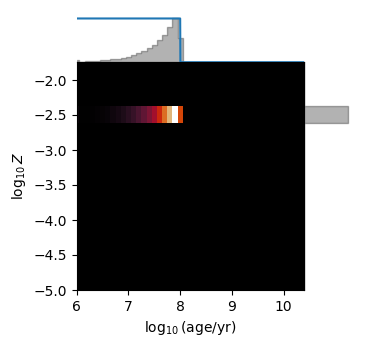

In [14]:
# Define a delta function for metallicity
metal_dist = ZDist.DeltaConstant(log10metallicity=-2.5)
print(metal_dist)

# Define a constant SFH
sfh = SFH.Constant(duration=100 * Myr)
print(sfh)

# Create the Stars object
const_stars = Stars(
    log10ages,
    metallicities,
    sf_hist=sfh,
    metal_dist=metal_dist,
    initial_mass=10**9,
)
print(const_stars)
fig, ax = const_stars.plot_sfzh(show=True)

### Combining `Stars`

We can also combine individual `Stars` objects together to produce more complicated star formation and metal enrichment histories by simply adding them.

+---------------------------------------------------------------------------+
|                                   STARS                                   |
+--------------------------+------------------------------------------------+
| Attribute                | Value                                          |
+--------------------------+------------------------------------------------+
| metallicity_grid_type    | 'log10Z'                                       |
+--------------------------+------------------------------------------------+
| log10ages_lims           | [6.0,  10.399999999999984, ]                   |
+--------------------------+------------------------------------------------+
| metallicities_lims       | [1e-05,  0.01778279410038923, ]                |
+--------------------------+------------------------------------------------+
| log10metallicities_lims  | [-5.0,  -1.75, ]                               |
+--------------------------+------------------------------------

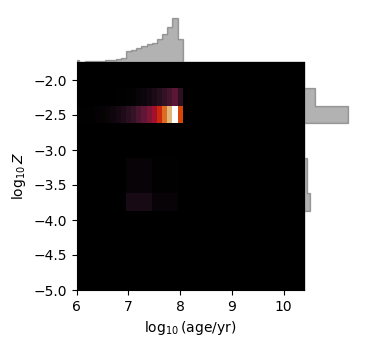

In [15]:
# Create an exponential Stars object
exp_stars = Stars(
    log10ages,
    metallicities,
    sf_hist=sfh,
    metal_dist=metal_dist,
    initial_mass=10**9.5,
)

# Create a log-normal Stars object
logn_stars = Stars(
    log10ages,
    metallicities,
    sf_hist=sfh,
    metal_dist=0.005,
    initial_mass=10**9,
)

combined = arr_stars + const_stars + exp_stars + logn_stars
print(combined)

fig, ax = combined.plot_sfzh()

#### Defining your own parametrisations

If synthesizer doesn't already include a parametrisation you need, you can add a custom parametrisation by defining a new class.

The important requirements of a custom function are:

- They inherit the `Common` parent class.

- They instantiate the parent class (`SFH/ZDist.Common`) with the model parameters and a meaningful name.

- They implement a private `_sfr` method which takes a single age and returns a single SFR weight in the `SFH` case, or they implement a `_weight` method which takes a single metallicity and returns a single metallicity weight in the `ZDist` case.

- The `SFH` methods should perform their calculations in *years*.

Below we demonstrate how to define a custom function using existing SFH and metallicity distribution functions for demonstration purposes.

----------
SUMMARY OF PARAMETERISED METAL ENRICHMENT HISTORY
<class '__main__.Normal'>
mean: 0.05
sigma: 0.001
----------

----------
SUMMARY OF PARAMETERISED STAR FORMATION HISTORY
<class '__main__.Constant'>
duration: 500 Myr
median age: 250.00 Myr
mean age: 250.00 Myr
----------

+---------------------------------------------------------------------------+
|                                   STARS                                   |
+--------------------------+------------------------------------------------+
| Attribute                | Value                                          |
+--------------------------+------------------------------------------------+
| sf_hist_func             | <__main__.Constant object at 0x7f2ee82c0070>   |
+--------------------------+------------------------------------------------+
| metal_dist_func          | <__main__.Normal object at 0x7f2ee82c0160>     |
+--------------------------+------------------------------------------------+
| metallicity_

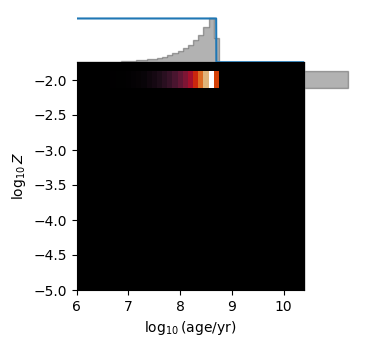

In [16]:
class Normal(ZDist.Common):
    """
    A normally distributed metallicity distribution.

    Attributes:
        mean (float)
            The mean of the normal distribution.
        sigma (float)
            The standard deviation of the normal distribution.
    """

    def __init__(self, mean, sigma):
        """
        Initialise the metallicity distribution and parent.

        Either metallicity or log10metallicity must be provided.

        Args:
            mean (float)
                The mean of the normal distribution.
            sigma (float)
                The standard deviation of the normal distribution.
        """

        # Instantiate the parent
        ZDist.Common.__init__(
            self,
            name="Normal",
            mean=mean,
            sigma=sigma,
        )

        # Define this models parameters
        self.mean = mean
        self.sigma = sigma

    def _weight(self, metal):
        """
        Return the distribution at a metallicity.

        Args:
            metal (float)
                The (linear) metallicity at which to evaluate the distribution.

        Returns:
            float
                The weight of the metallicity distribution at metal.
        """
        norm = 1 / (self.sigma * np.sqrt(2 * np.pi))
        exponent = ((metal - self.mean) / self.sigma) ** 2
        return norm * np.exp(-0.5 * exponent)


class Constant(SFH.Common):
    """
    A constant star formation history.

    The SFR is defined such that:
        sfr = 1; t<=duration
        sfr = 0; t>duration

    Attributes:
        duration (float)
            The duration of the period of constant star formation.
    """

    def __init__(self, duration):
        """
        Initialise the parent and this parametrisation of the SFH.

        Args:
            duration (unyt_quantity)
                The duration of the period of constant star formation.
        """

        # Initialise the parent
        SFH.Common.__init__(self, name="Constant", duration=duration)

        # Set the model parameters
        self.duration = duration.to("yr").value

    def _sfr(self, age):
        """
        Get the amount SFR weight in a single age bin.

        Args:
            age (float)
                The age (in years) at which to evaluate the SFR.
        """

        # Set the SFR based on the duration.
        if age <= self.duration:
            return 1.0
        return 0.0


# Define a scaled delta function for metallicity
metal_dist = Normal(mean=0.05, sigma=0.001)
print(metal_dist)

# Define an exponential SFH
sfh = Constant(duration=500 * Myr)
print(sfh)

# Create the Stars object
custom_stars = Stars(
    log10ages,
    metallicities,
    sf_hist=sfh,
    metal_dist=metal_dist,
    initial_mass=10**9,
)
print(custom_stars)
fig, ax = custom_stars.plot_sfzh(show=True)